# New York Hospital Inpatient Discharges in 2015

Hi! I'm Theresia Evelyn, A Health Data Enthusiast. This is my Final Project in order to complete Dibimbing Data Science Batch 13 Bootcamp. The dataset I use here is a public dataset provided by [New York State Department of Health](https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/82xm-y6g8).

Length of Stay is a clinical metric that measures the length of time elapsed between a patient's hospital admittance and discharge. It's an important indicator of the efficiency of hospital management. Here I am trying to predict New York Hospital Inpatient Discharges Data in 2015.

This is the continuation from **[previous colab](https://colab.research.google.com/drive/1N_fuOFMjsD6M951-FoW5kV5-YdXkeLlr?usp=sharing)**, after the features get filtered by the regression.

# Import Libraries

In [1]:
# First we'll import the basic libraries that we'll use in this project
import pandas as pd
import numpy as np

# For the visualization
import seaborn as sns
import matplotlib.pyplot as plt

# For splitting train test
from sklearn.model_selection import train_test_split

# VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

# For Modelling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# For Evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from numpy import math
import warnings
warnings.filterwarnings('ignore')

# Load The Dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Load the dataset we'll use here
data = pd.read_csv('/content/gdrive/MyDrive/Dibimbing DS13/FINPRO WML/Hospital Inpatient Discharges NY 2015.csv')
data.head()

,Health Service Area,Hospital County,Operating Certificate Number,Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Cattaraugus,401001.0,66.0,Olean General Hospital,50 to 69,147,F,White,Not Span/Hispanic,...,NaN,NaN,267162.0,NaN,NaN,0,N,Y,$5620.00,$4561.28
1,Western NY,Cattaraugus,401001.0,66.0,Olean General Hospital,18 to 29,147,F,White,Not Span/Hispanic,...,NaN,NaN,275408.0,NaN,NaN,0,N,Y,$7404.18,$6933.94
2,Western NY,Cattaraugus,401001.0,66.0,Olean General Hospital,30 to 49,147,M,White,Not Span/Hispanic,...,NaN,NaN,267162.0,NaN,NaN,0,N,Y,$7931.28,$7154.85
3,Western NY,Cattaraugus,401001.0,66.0,Olean General Hospital,50 to 69,147,F,White,Not Span/Hispanic,...,NaN,NaN,271326.0,NaN,NaN,0,N,Y,$11304.44,$4584.11
4,Western NY,Chautauqua,602001.0,103.0,Woman's Christian Association,50 to 69,147,M,White,Not Span/Hispanic,...,NaN,NaN,243034.0,NaN,NaN,0,N,Y,$8330.50,$4361.74


In [4]:
# Dig more infos about this dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346760 entries, 0 to 2346759
Data columns (total 37 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Health Service Area                  object 
 1   Hospital County                      object 
 2   Operating Certificate Number         float64
 3   Facility Id                          float64
 4   Facility Name                        object 
 5   Age Group                            object 
 6   Zip Code - 3 digits                  object 
 7   Gender                               object 
 8   Race                                 object 
 9   Ethnicity                            object 
 10  Length of Stay                       object 
 11  Type of Admission                    object 
 12  Patient Disposition                  object 
 13  Discharge Year                       int64  
 14  CCS Diagnosis Code                   int64  
 15  CCS Diagnosis Description       

In [5]:
data.shape

(2346760, 37)

**We can conclude that:**

- This dataset consists of 2.346.760 rows and 37 features
- The target column, `Length of Stay`, is still object dtype, so we'll need to change it later
- We'll drop `Facility Id` and `Discharge Year` later, because we won't use them
- We'll have to encode some categorical data and
- We'll need to check the correlation and multicollinearity among the numeric features.

**Columns (Features) Understanding**

- `Health Service Area`: Where the hospital is located
- `Hospital County`: The county in which the hospital is located
- `Facility Name`: The name of the facility
- `Age Group`: Age in years at time of discharge
- `Gender`: Patient gender 
- `Race`: Patient race
- `Ethnicity`: Patient Ethnicity
- `Length of Stay`: The total number of patient days at hospital
- `Type of Admission`: The manner in which the patient was admitted to hospital 
- `Patient Disposition`: The patient's destination or status upon discharge
- `CCS Diagnosis Description`: Clinical Classification Software (CCS) Diagnosis
Category Description 
- `CCS Procedure Description`: Clinical Classification Software (CCS) Procedure
Category Description  
- `APR DRG Description`: APR-DRG Classification Code Description 
- `APR MDC Description`: All Patient Refined Major Diagnostic Category Description
- `APR Severity of Illness Code`: APR-DRG Severity of Illness Code 
- `APR Severity of Illness Description`: All Patient Refined Severity of Illness (APR SOI) Description 
- `APR Risk of Mortality`: All Patient Refined Risk of Mortality 
- `APR Medical Surgical Description`: APR-DRG specific classification of Medical 
- `Payment Typology 1`: A description of the type of payment for this occurrence 
- `Birth Weight`: The neonate birth weight in grams; rounded to nearest 100g
- `Abortion Edit Indicator`: A flag to indicate if the discharge record contains any indication of abortion 
- `Emergency Department Indicator`: If the record contained an Emergency Department revenue, the indicator is set to "Y", otherwise it will be “N”.
- `Total Charges`: Total charges for the discharge
- `Total Costs`: Total estimated costs for the discharge


# Data Prepocessing

## Handling Duplicated Value

In [6]:
# Check duplicated values

print('Duplicated values : ', data.duplicated().sum())
print('Percentage of duplicated values : ', data.duplicated().sum()/len(data)*100)

Duplicated values :  2273
Percentage of duplicated values :  0.0968569431897595


In [7]:
print('Rows before dropping duplicated values :', len(data))

Rows before dropping duplicated values : 2346760


In [8]:
# Drop duplicated data
data = data.drop_duplicates()
print('Rows after dropping duplicated values :', len(data))

Rows after dropping duplicated values : 2344487


## Handling Missing Value



In [9]:
# Find out how many null data this dataset has
# Make a dataframe of missing value for easy reading
data_nan = data.isna().sum().reset_index()
data_nan.columns = ['feature','missing_value']
data_nan['percentage'] = round((data_nan['missing_value']/len(data))*100,2)
data_nan = data_nan.sort_values('percentage', ascending=False).reset_index(drop=True)
data_nan = data_nan[data_nan['percentage']>0]
data_nan

,feature,missing_value,percentage
0,Other Provider License Number,2273151,96.96
1,Payment Typology 3,1644073,70.13
2,Payment Typology 2,761749,32.49
3,Operating Provider License Number,612265,26.12
4,Zip Code - 3 digits,4425,0.19
5,Hospital County,2911,0.12
6,Attending Provider License Number,2911,0.12
7,Health Service Area,2911,0.12
8,Facility Id,2911,0.12
9,Operating Certificate Number,2911,0.12


**We'll need to drop `Other Provider License Number`, `Payment Typology 3`, `Payment Typology 2` and `Operating Provider License Number` because they contain too much Null value (more than 5%).**

In [10]:
print('Rows before dropping missing values and redundant feature :', len(data))

Rows before dropping missing values and redundant feature : 2344487


In [11]:
# We are dropping `Other Provider License Number`, `Payment Typology 3`, `Operating Provider License Number` and `Payment Typology 2` features

data = data.drop('Other Provider License Number', axis=1)
data = data.drop('Payment Typology 3', axis=1)
data = data.drop('Operating Provider License Number', axis=1)
data = data.drop('Payment Typology 2', axis=1)

In [12]:
# How many null value we have now, after dropping those four redundant features? 
data_nan = data.isna().sum().reset_index()
data_nan.columns = ['feature','missing_value']
data_nan['percentage'] = round((data_nan['missing_value']/len(data))*100,2)
data_nan = data_nan.sort_values('percentage', ascending=False).reset_index(drop=True)
data_nan = data_nan[data_nan['percentage']>0]
data_nan

,feature,missing_value,percentage
0,Zip Code - 3 digits,4425,0.19
1,Health Service Area,2911,0.12
2,Hospital County,2911,0.12
3,Attending Provider License Number,2911,0.12
4,Facility Id,2911,0.12
5,Operating Certificate Number,2911,0.12


In [13]:
# Check the last missing value percentage

(data_nan['missing_value'].sum()/len(data))*100

0.8095587648811872

**Now we can drop the missing value, because it's only less than 1%.**

In [14]:
# Drop missing values

data = data.dropna()
print('Rows after dropping missing values : ', len(data))

Rows after dropping missing values :  2339950


## Data Wrangling

In [15]:
# After doing a recheck, we're dropping these redundant and unusable features, mostly because we won't use it later on
data = data.drop('Facility Id', axis=1)
data = data.drop('Discharge Year', axis=1)
data = data.drop('Operating Certificate Number', axis=1)
data = data.drop('Zip Code - 3 digits', axis=1)
data = data.drop('CCS Diagnosis Code', axis=1)
data = data.drop('CCS Procedure Code', axis=1)
data = data.drop('APR DRG Code', axis=1)
data = data.drop('APR MDC Code', axis=1)
data = data.drop('Attending Provider License Number', axis=1)
data = data.drop('Total Costs', axis=1)
data = data.drop('Abortion Edit Indicator', axis=1)
data = data.drop('APR Severity of Illness Code', axis=1)

In [16]:
data['Gender'].value_counts()

F    1302219
M    1037692
U         39
Name: Gender, dtype: int64

In [17]:
# For easier analysis
data['Gender'] = data['Gender'].replace('U', 'F')

In [18]:
# Recheck how many features we have now
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339950 entries, 0 to 2346759
Data columns (total 21 columns):
 #   Column                               Dtype 
---  ------                               ----- 
 0   Health Service Area                  object
 1   Hospital County                      object
 2   Facility Name                        object
 3   Age Group                            object
 4   Gender                               object
 5   Race                                 object
 6   Ethnicity                            object
 7   Length of Stay                       object
 8   Type of Admission                    object
 9   Patient Disposition                  object
 10  CCS Diagnosis Description            object
 11  CCS Procedure Description            object
 12  APR DRG Description                  object
 13  APR MDC Description                  object
 14  APR Severity of Illness Description  object
 15  APR Risk of Mortality                object
 16  

We have successfully dropped missing values, duplicated data and redundant features. **Our previous rows were 2.346.760, now we have 2.339.950 rows and 21 columns.**

Now we need to transform several incorrect dtype such as: `Length of Stay` (the target itself) and `Total Charges`. We'll need to check their unique values first.

In [19]:
# Find out the possibility of incorrect values or format in `Length of Stay`
data['Length of Stay'].unique()

array(['5', '8', '4', '3', '2', '9', '1', '59', '10', '17', '35', '15',
       '12', '7', '98', '26', '6', '46', '32', '16', '21', '22', '13',
       '77', '14', '58', '28', '11', '18', '19', '29', '27', '42', '24',
       '23', '31', '37', '57', '25', '20', '30', '63', '43', '49', '45',
       '102', '56', '33', '40', '34', '55', '100', '47', '38', '61', '53',
       '117', '62', '120 +', '80', '48', '70', '44', '51', '41', '64',
       '50', '36', '107', '68', '74', '39', '87', '83', '54', '105', '81',
       '112', '76', '91', '86', '66', '72', '94', '93', '67', '69', '73',
       '119', '115', '75', '97', '92', '95', '60', '65', '82', '79', '71',
       '84', '109', '103', '118', '52', '101', '85', '110', '106', '88',
       '111', '104', '89', '78', '116', '90', '113', '108', '114', '96',
       '99', 22, 4, 3, 10, 8, 2, 7, 16, 1, 18, 5, 6, 9, 14, 17, 12, 15,
       11, 27, 30, 65, 41, 28, 21, 13, 36, 20, 49, 32, 45, 29, 25, 50, 70,
       47, 44, 43, 33, 46, 80, 19, 40, 23, 63, 5

In [20]:
# Find out the possibility of incorrect values or format in `Total Costs`
data['Total Charges'].unique()

array(['$5620.00', '$7404.18', '$7931.28', ..., '$177142.00', '$17567.20',
       '$109189.00'], dtype=object)

In [21]:
# Change incorrect format inside the dataset so that we can change their inappropriate dtype
data['Length of Stay'] = data['Length of Stay'].replace('120 +', '120')
data['Total Charges'] = data['Total Charges'].str.replace('$', '')

In [22]:
# Change the incorrect dtype
data['Length of Stay'] = data['Length of Stay'].astype(float)
data['Total Charges'] = data['Total Charges'].astype(float)

In [23]:
# Recheck the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339950 entries, 0 to 2346759
Data columns (total 21 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Health Service Area                  object 
 1   Hospital County                      object 
 2   Facility Name                        object 
 3   Age Group                            object 
 4   Gender                               object 
 5   Race                                 object 
 6   Ethnicity                            object 
 7   Length of Stay                       float64
 8   Type of Admission                    object 
 9   Patient Disposition                  object 
 10  CCS Diagnosis Description            object 
 11  CCS Procedure Description            object 
 12  APR DRG Description                  object 
 13  APR MDC Description                  object 
 14  APR Severity of Illness Description  object 
 15  APR Risk of Mortality           

We've successfully change the incorrect dtype (`Length of Stay` and `Total Charges`).

## Statistical Summary

In [24]:
# Categorize the data to simplifiy the Statistical Summary
cat = ['Age Group', 'Gender', 'Type of Admission', 'Patient Disposition']
num = ['Length of Stay', 'Birth Weight', 'Total Charges']

In [25]:
data[num].describe()

,Length of Stay,Birth Weight,Total Charges
count,2.339950e+06,2.339950e+06,2.339950e+06
mean,5.483206e+00,3.241779e+02,4.326461e+04
std,8.038450e+00,9.972320e+02,8.049209e+04
min,1.000000e+00,0.000000e+00,1.000000e-02
25%,2.000000e+00,0.000000e+00,1.205801e+04
50%,3.000000e+00,0.000000e+00,2.352841e+04
75%,6.000000e+00,0.000000e+00,4.668045e+04
max,1.200000e+02,9.900000e+03,7.248391e+06


**Observations :**

- Mean is not any close to 50% (Median) in `Birth Weight` and `Total Charges` column, somehow indicating not symmetrical distribution.

In [26]:
data[cat].describe()

,Age Group,Gender,Type of Admission,Patient Disposition
count,2339950,2339950,2339950,2339950
unique,5,2,6,19
top,50 to 69,F,Emergency,Home or Self Care
freq,644728,1302258,1485048,1565881


**Observations:**
- 28% Patients are between 50 to 69 years old,
- Half of the patients are female,
- 64% Patients were admitted from emergency,
- Patients mostly continue their treatment in Home or Self Care.


In [27]:
# Additional check the target feature
data['Length of Stay'].value_counts()

2.0      540638
3.0      423817
1.0      336983
4.0      247310
5.0      160519
          ...  
111.0        41
119.0        41
115.0        37
116.0        31
108.0        26
Name: Length of Stay, Length: 120, dtype: int64

**We can conclude that even if there is a few patients that need to stay for more than 120 days, 73% among the patients are staying for around 5 days. The distribution would definitely asymmetrical, we need to reduce the skewness later.**

## Target Distribution Skewness

In [28]:
data['Length of Stay'].describe()

count    2.339950e+06
mean     5.483206e+00
std      8.038450e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      1.200000e+02
Name: Length of Stay, dtype: float64

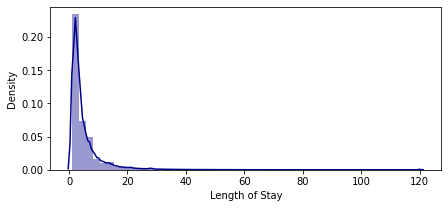

In [29]:
# Distribution plot of Length of Stay

plt.figure(figsize=(7,3))
plt.xlabel('Length of Stay')
plt.ylabel('Density')
ax=sns.distplot(data['Length of Stay'],hist=True ,color="darkblue")
plt.show()

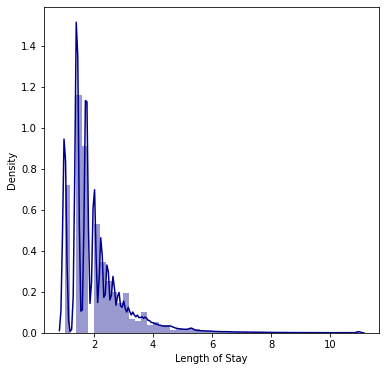

In [30]:
#Applying square root to Length of Stay to reduce skewness

plt.figure(figsize=(6,6))
plt.xlabel('Length of Stay')
plt.ylabel('Density')

ax=sns.distplot(np.sqrt(data['Length of Stay']), color="darkblue")

plt.show()

# Exploratory Data Analysis

## Univariate Analysis

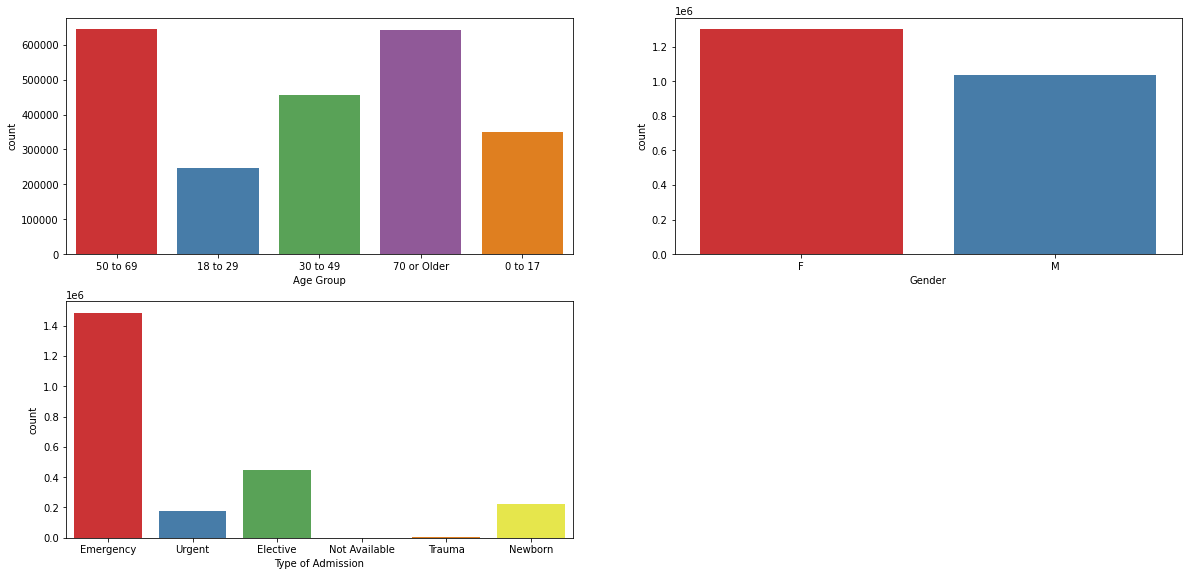

In [42]:
plt.figure(figsize = (20,20))

plt.subplot(4,2,1)
sns.countplot(x = 'Age Group', palette='Set1', data = data)

plt.subplot(4,2,2)
sns.countplot(x = 'Gender', palette='Set1', data = data)

plt.subplot(4,2,3)
sns.countplot(x = 'Type of Admission', palette='Set1', data = data)


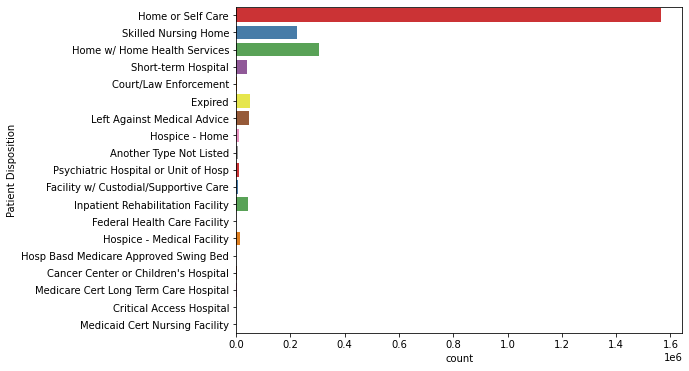

In [51]:
plt.figure(figsize = (8,6))
plt.subplot
sns.countplot(y = 'Patient Disposition', palette='Set1', data = data)
plt.show()

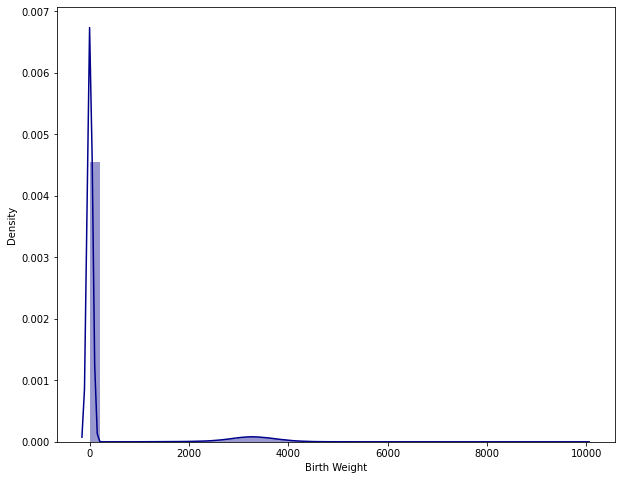

In [39]:
plt.figure(figsize=(10, 8))
plt.xlabel('Birth Weight')
plt.ylabel('Density')
ax=sns.distplot(data['Birth Weight'],hist=True ,color="darkblue")
plt.show()

## Bivariate Analysis

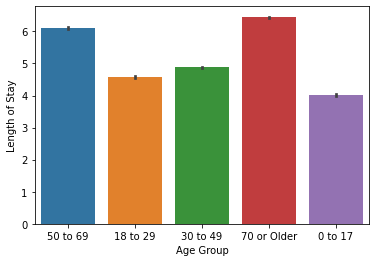

In [46]:
sns.barplot(x = data['Age Group'],
            y = data['Length of Stay']) 

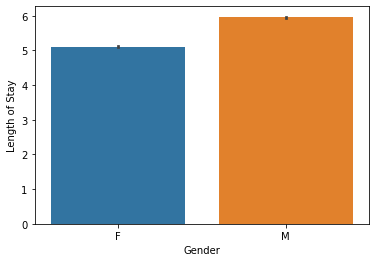

In [43]:
sns.barplot(x = data['Gender'],
            y = data['Length of Stay']) 

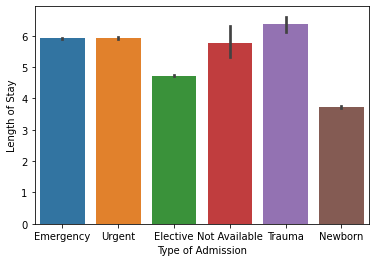

In [48]:
sns.barplot(x = data['Type of Admission'],
            y = data['Length of Stay']) 

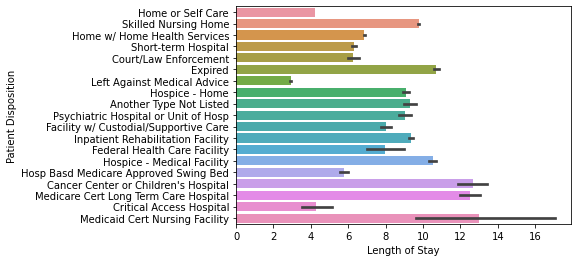

In [34]:
sns.barplot(y = data['Patient Disposition'],
            x = data['Length of Stay']) 
plt.show()

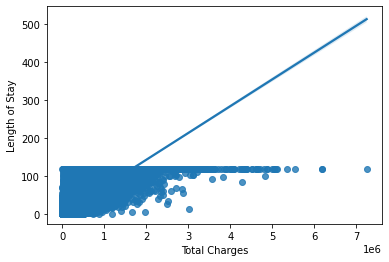

In [50]:
# draw regplot
sns.regplot(x = 'Total Charges', 
            y = 'Length of Stay', 
            data = data)

## Multivariate Analysis

In [31]:
dataGender = data.groupby(['Age Group', 'Gender', 'APR MDC Description']).agg(
    meanLOS=('Length of Stay','mean')
).reset_index()
dataGender = dataGender.sort_values('meanLOS', ascending=False).reset_index(drop=True)
dataGender.head(20)

,Age Group,Gender,APR MDC Description,meanLOS
0,70 or Older,M,Burns,16.322917
1,70 or Older,F,Burns,15.252525
2,50 to 69,F,Mental Diseases and Disorders,15.143664
3,50 to 69,M,Mental Diseases and Disorders,14.462935
4,70 or Older,F,Mental Diseases and Disorders,14.055001
5,70 or Older,M,Mental Diseases and Disorders,13.254522
6,18 to 29,M,"Rehabilitation, Aftercare, Other Factors Influ...",12.795508
7,0 to 17,M,"Rehabilitation, Aftercare, Other Factors Influ...",12.763851
8,30 to 49,M,Multiple Significant Trauma,12.693739
9,0 to 17,F,Multiple Significant Trauma,12.534247


In [32]:
dataGenderCost = data.groupby(['Age Group', 'Gender', 'APR MDC Description']).agg(
    meanLOS=('Length of Stay','mean'), meanCost=('Total Charges', 'mean')
).reset_index()
dataGenderCost = dataGenderCost.sort_values('meanLOS', ascending=False).reset_index(drop=True)
dataGenderCost.head(20)

,Age Group,Gender,APR MDC Description,meanLOS,meanCost
0,70 or Older,M,Burns,16.322917,191330.983021
1,70 or Older,F,Burns,15.252525,172326.095960
2,50 to 69,F,Mental Diseases and Disorders,15.143664,45418.274293
3,50 to 69,M,Mental Diseases and Disorders,14.462935,42155.722357
4,70 or Older,F,Mental Diseases and Disorders,14.055001,52200.908025
5,70 or Older,M,Mental Diseases and Disorders,13.254522,51114.879657
6,18 to 29,M,"Rehabilitation, Aftercare, Other Factors Influ...",12.795508,62003.843522
7,0 to 17,M,"Rehabilitation, Aftercare, Other Factors Influ...",12.763851,69762.720990
8,30 to 49,M,Multiple Significant Trauma,12.693739,138317.736548
9,0 to 17,F,Multiple Significant Trauma,12.534247,134928.435616
